# Introduction

Purpose:
  * Load the Narrative-Event ontologies and a set of narratives/stories into a Stardog database
  * Create a "word cloud" of the top 50 words in the initial set of narratives
 
Before running this program, make sure that:
  * Stardog is started (via the command, stardog-admin server start) 
  * The dna.config file (used in the second executing cell) has been updated for your environment

This notebook should only be run once! To add or remove narratives, use the Add_Parse_NarrativeText or Remove_NarrativeText notebooks. OR, to drop the database and reload it, execute the command, _'stardog-admin db drop <narratives_db_name>'_ and then re-'run' the steps in this notebook, as well as the other 'Prep_' notebooks.

## Imports

In [1]:
# Load all libraries
import os, sys
import configparser as cp
import stardog

# Load WordCloud and its prerequisites
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 

# Load plotting libraries (not needed if cells 6 and 7 are not run)
import matplotlib.pyplot as plt 
%matplotlib inline

## Functions

In [2]:
def loadDirectoryFilesToDB(directoryName, conn):
    listFiles = os.listdir(directoryName)
    for file in listFiles:
        if file.endswith('.ttl'):
            conn.add(stardog.content.File(f'{directoryName}{file}'))

# Get configuration details from dna.config

In [3]:
# Get details from the dna.config file, stored in the same directory as the .ipynb file
config = cp.RawConfigParser()
config.read('dna.config')
        
# Set Stardog connection details
sdConnDetails = {
    'endpoint': config.get('StardogConfig', 'endpoint'),
    'username': config.get('StardogConfig', 'username'),
    'password': config.get('StardogConfig', 'password') }

# Set Stardog database name
dbName = config.get('StardogConfig', 'dbName')

# Set path to directory where ontologies stored
ontolPath = config.get('OntologiesConfig', 'ontolPath')
if not ontolPath.endswith('/'):
    ontolPath = f'{ontolPath}/'

# Set path to directory where narratives stored
narrPath = config.get('NarrativesConfig', 'narrPath')
if not narrPath.endswith('/'):
    narrPath = f'{narrPath}/'

# Create 'Narratives' database, and load the ontologies + narrative text

In [4]:
# Create database
admin = stardog.Admin(**sdConnDetails)
db = admin.new_database(dbName, {'search.enabled': True, 'edge.properties' : True, 'reasoning' : True,
                                 'preserve.bnode.ids' : False, 'reasoning.punning.enabled' : True})

# Open connection to Stardog
conn = stardog.Connection(dbName, **sdConnDetails)

In [5]:
# Load main, plants and geonames ontologies
conn.begin()
loadDirectoryFilesToDB(ontolPath, conn)
conn.commit()

In [6]:
# Save all narrative contents for WordCloud ouput in the following cells
stories_content = ' '

# Load narratives
conn.begin()
bites = conn.docs()
with os.scandir(narrPath) as stories:
    for story in stories:
        bites.add(story.name, stardog.content.File(story.path))
        with open(story.path, 'r') as s:
            content = s.read()
        stories_content = f'{stories_content} {content}'    
conn.commit()

# Count narratives in the store
print(f'{bites.size()} documents were read into the store.')

21 documents were read into the store.


# Generate WordCloud (optional)

**Note:** Depending on the number of narratives, the processing to create the WordCloud may take some time.

In [7]:
# Output scrolling only required for "large" images (> 750 pixels)
from IPython.core.display import display, HTML
display(HTML('<style>div.output_scroll { height: 750px; }</style>'))

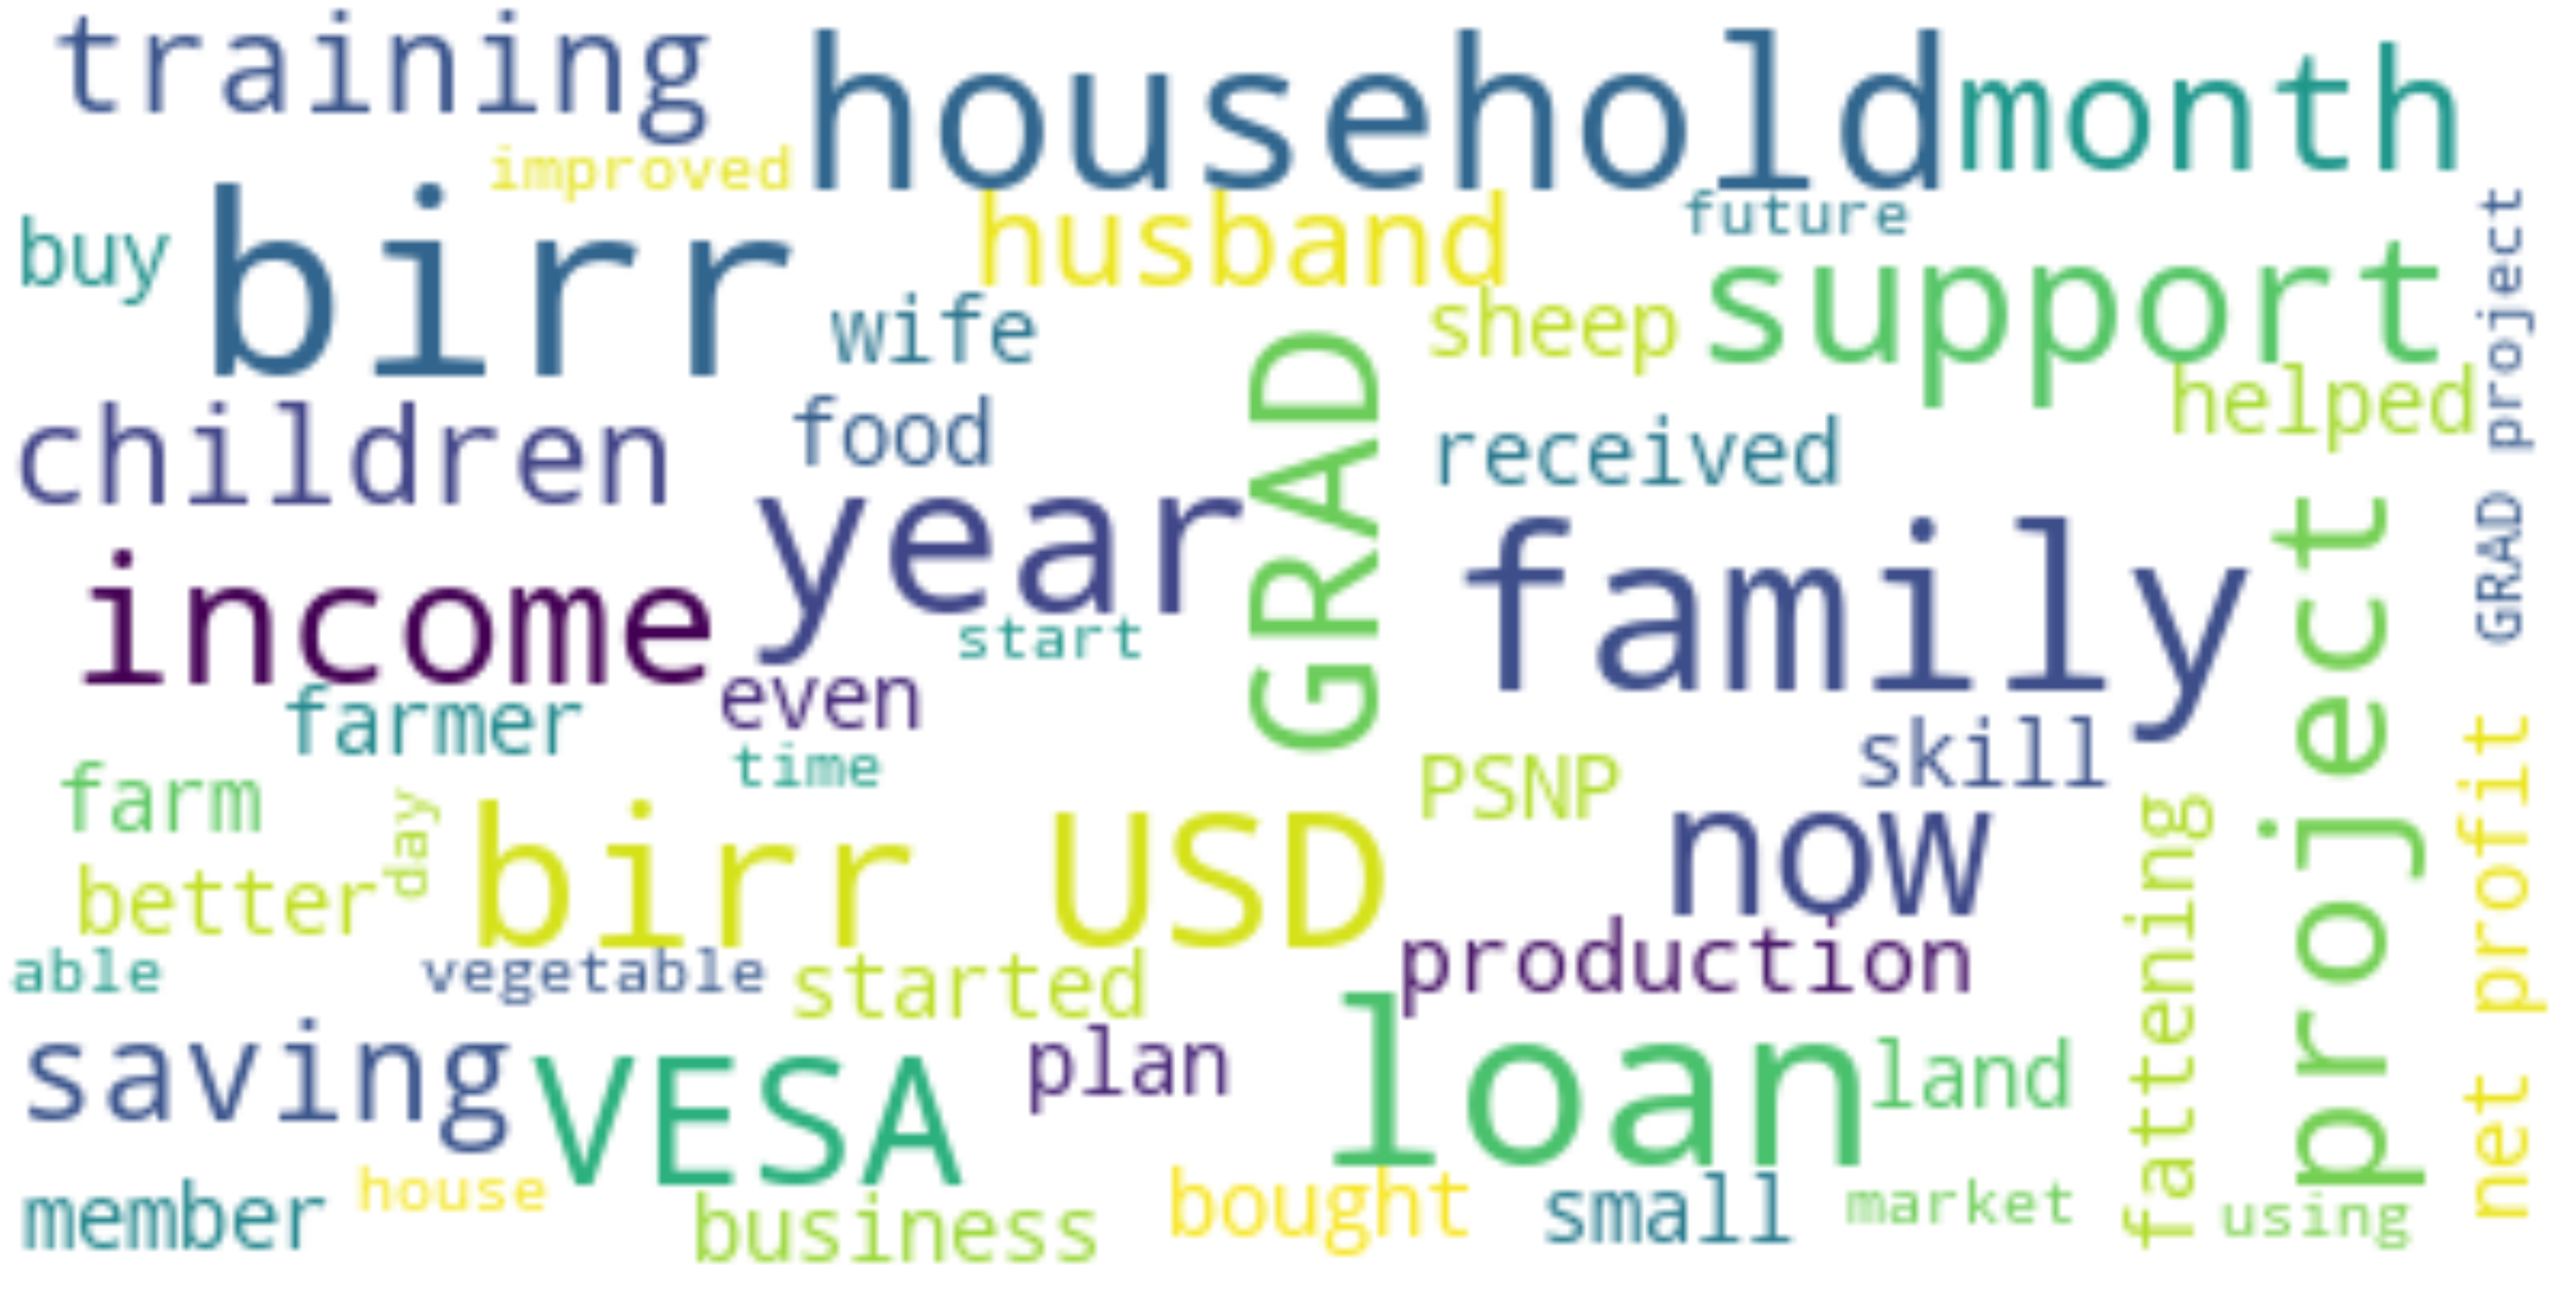

In [8]:
# Size the WordCloud plot
plt.rcParams['figure.figsize'] = [100,50]

# Set stop-words (words to ignore)
stopwords = set(STOPWORDS)
stopwords.update(["will", "per", "us", "said",
                  "one", "two", "three", "four", "five", "six", 
                  "seven", "eight", "nine",
                  "first", "second", "third", "fourth", "fifth",
                  "sixth", "seventh", "eighth", "ninth"])

# Create WordCloud of top 50 words in all documents 
wordcloud = WordCloud(stopwords=stopwords, max_font_size=40, max_words=50, 
                      background_color='white').generate(stories_content)

# Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()